In [ ]:
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Task 1: 데이터 준비하기

# 데이터 읽기, 정리
item = pd.read_csv('./u.item', sep = '|', names = ['id', 'title', 'release date', 'video release date', 'url', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery','Romance', 'Sci-Fi','Thriller', 'War', 'Western'], encoding='latin-1')
train = pd.read_csv('./ua.base', sep = '\t', names = ['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv('./ua.test', sep = '\t', names = ['user', 'movie', 'rating', 'timestamp'])

# 요소들 텐서로 만들기
movies = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

movies_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

# 영화 id, title 불러오기
ids = item['id']
titles = item['title']

epoch: 0, training RMSE: 6.501067, test RMSE: 5.753471
epoch: 100, training RMSE: 0.638994, test RMSE: 0.944409
epoch: 200, training RMSE: 0.601559, test RMSE: 0.938568
epoch: 300, training RMSE: 0.593459, test RMSE: 0.939334
epoch: 400, training RMSE: 0.590875, test RMSE: 0.940349
epoch: 500, training RMSE: 0.589826, test RMSE: 0.940920
epoch: 600, training RMSE: 0.589231, test RMSE: 0.941673
epoch: 700, training RMSE: 0.588818, test RMSE: 0.942491
epoch: 800, training RMSE: 0.588506, test RMSE: 0.943136
epoch: 900, training RMSE: 0.588295, test RMSE: 0.943481


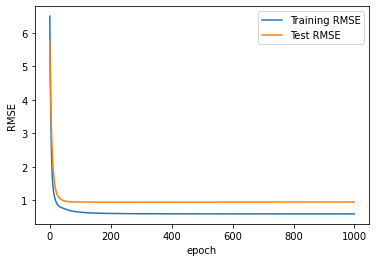

In [ ]:
# Task 2: Latent Factor 모델을 이용하여 학습하기

# P, Q, bias_user, bias_movie 등 파라미터 초기화하기
rank = 40
numMovies = movies.max() + 1
numUsers = users.max() + 1
X = []
Y = []
Y_test = []

# 학습시키는 네 개
P = torch.randn(numMovies, rank, requires_grad = True)
Q = torch.randn(numUsers, rank, requires_grad = True)
bias_movie = torch.randn(numMovies, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)

optimizer = torch.optim.Adam([P, Q, bias_movie, bias_user], lr=0.1) 

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.0001
lambda4 = 0.0001

mean = (ratings.sum() / len(ratings)).item()

for epoch in range(1000):
  # regularization, bias 적용
  hypothesis = torch.sum(P[movies] * Q[users], dim = 1) + mean + bias_movie[movies] + bias_user[users]
  cost = F.mse_loss(hypothesis, ratings) + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_movie ** 2) + lambda4 * torch.sum(bias_user ** 2)

  # 학습
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    hypo_test = torch.sum(P[movies_test] * Q[users_test], dim = 1) + mean + bias_movie[movies_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)

    # RMSE 계산
    trainig_RMSE = torch.mean((hypothesis - ratings) ** 2) ** 0.5
    test_RMSE = torch.mean((hypo_test - ratings_test) ** 2) ** 0.5
    
  X.append(epoch)
  Y.append(trainig_RMSE.item())
  Y_test.append(test_RMSE.item())

  if epoch % 100 == 0:
    print("epoch: {}, training RMSE: {:.6f}, test RMSE: {:.6f}".format(epoch, trainig_RMSE.item(), test_RMSE.item()))
  
plt.ylabel("RMSE")
plt.xlabel("epoch")
plt.plot(X, Y, label="Training RMSE")
plt.plot(X, Y_test, label = "Test RMSE")
plt.legend()
plt.show()

In [ ]:
# Task 3: 13번 User에게 추천하기 (knn search)

# Task 3-1
with torch.no_grad():
 u13_ratings1 = [(idx, torch.sum(p * Q[13]) + mean + bias_movie[idx] + bias_user[13]) for idx, p in enumerate(P)]

u13_ratings1.sort(key = lambda x:x[1], reverse = True) # u13_ratings1를 평점을 기준으로 내림차순 정렬

print("< User13's Recommendation >")
for i in range(20):
  print("{}. id: {}, title: {}".format(i+1, u13_ratings1[i][0], titles[u13_ratings1[i][0] - 1])) # u13_ratings1[i][0]은 i번째로 높은 평점 영화의 id값

# Task 3-2
with torch.no_grad():  
  u13_ratings2 = [(idx, torch.sum(p * Q[13]) / np.sqrt(torch.sum(p ** 2) * torch.sum(Q[13] ** 2))) for idx, p in enumerate(P)] # 튜플의 두번째 원소가 P와 Q[13]의 cosine similarity

u13_ratings2.sort(key = lambda x:x[1], reverse = True)

print("\n< User13's Cosine Similarity Recommendation >")
for i in range(20):
  print("{}. id: {}, title: {}".format(i+1, u13_ratings2[i][0], titles[u13_ratings2[i][0] - 1])) # u13_ratings2[i][0]은 i번째로 높은 평점 영화의 id값

< User13's Recommendation >
1. id: 215, title: Field of Dreams (1989)
2. id: 202, title: Groundhog Day (1993)
3. id: 663, title: Being There (1979)
4. id: 511, title: Lawrence of Arabia (1962)
5. id: 187, title: Godfather: Part II, The (1974)
6. id: 423, title: E.T. the Extra-Terrestrial (1982)
7. id: 181, title: Return of the Jedi (1983)
8. id: 655, title: Stand by Me (1986)
9. id: 4, title: Get Shorty (1995)
10. id: 204, title: Back to the Future (1985)
11. id: 302, title: L.A. Confidential (1997)
12. id: 430, title: Duck Soup (1933)
13. id: 510, title: Magnificent Seven, The (1954)
14. id: 50, title: Star Wars (1977)
15. id: 285, title: Secrets & Lies (1996)
16. id: 484, title: Maltese Falcon, The (1941)
17. id: 161, title: Top Gun (1986)
18. id: 661, title: High Noon (1952)
19. id: 483, title: Casablanca (1942)
20. id: 514, title: Annie Hall (1977)

< User13's Cosine Similarity Recommendation >
1. id: 814, title: Great Day in Harlem, A (1994)
2. id: 868, title: Hearts and Minds (19

if k = 1, cost = 1599.5999078527093
if k = 2, cost = 1268.3988068718463
if k = 3, cost = 1184.3921290561557
if k = 4, cost = 1154.6307401172817
if k = 5, cost = 1116.3967773765326
if k = 6, cost = 1083.2552924603224
if k = 7, cost = 1070.743949510157
if k = 8, cost = 1052.0554528832436
if k = 9, cost = 1035.9586974307895
if k = 10, cost = 1014.1919057369232
if k = 11, cost = 1018.0443211272359
if k = 12, cost = 1000.4032203555107
if k = 13, cost = 986.4400691241026
if k = 14, cost = 968.0704048722982
if k = 15, cost = 958.3948990851641
if k = 16, cost = 955.9275459647179
if k = 17, cost = 946.7318294644356
if k = 18, cost = 945.5473783165216
if k = 19, cost = 944.6760131195188
if k = 20, cost = 936.0309961289167
if k = 21, cost = 909.61617423594
if k = 22, cost = 901.7701002210379
if k = 23, cost = 917.7810160368681
if k = 24, cost = 902.7201808393002
if k = 25, cost = 898.2963737100363
if k = 26, cost = 893.2259819209576
if k = 27, cost = 890.7838681340218
if k = 28, cost = 866.879795

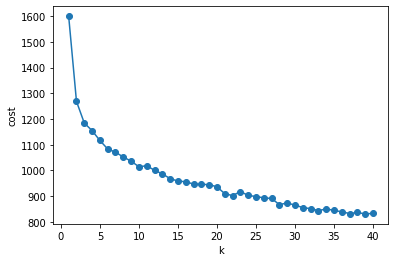

In [ ]:
# Task 4: 영화 클러스터링하기 (k-means clustering)

def assign(point, centroids):
  max_cos_sim_centroids_idx = -1
  max_cos_sim = -2
    
  for i, c in enumerate(centroids):
    cos_sim = 0

    # 두 벡터 단위벡터로 만들기(0으로 나눈다는 경고 없애기 위해) --> 크기 1이니까 cos sim 구할때 따로 안나눠 줘도 됨
    point = point / np.sqrt(np.sum(point ** 2))
    c = c / np.sqrt(np.sum(c ** 2))

    cos_sim = np.sum(point * c) # cluster 정하는 기준은 cosine similarity, 분모는 1이라서 생략

    if max_cos_sim < cos_sim:
      max_cos_sim_centroids_idx = i
      max_cos_sim = cos_sim
  
  return max_cos_sim_centroids_idx


# 새로운 centroids 계산해주는 함수
def compute_centroids(assignments, points, k):
  clusters = [ [] for _ in range(k)]

  # point를 해당 cluster 배열에 넣음
  for a, p in zip(assignments, points):
    clusters[a].append(p)

  return [np.mean(c, axis=0) for c in clusters] 


# cosine distance의 합인 cost를 계산해주는 함수
def compute_cost(centroids, assignments, points):
  cost = 0

  for i, c in enumerate(centroids):
    for a, p in zip(assignments, points):
      if a != i:
        continue
      else:
        # 두 벡터 단위벡터 만들기
        c = c / np.sqrt(np.sum(c ** 2))
        p = p / np.sqrt(np.sum(p ** 2))

        cost += 1 - np.sum(c * p) # cost는 cosine distance의 합, cos sim의 분모는 1이라 생략
  
  return cost

# Task 4-1
def kmeans(k, points):
  prev_assignment = []

  centroids = points[np.random.choice(points.shape[0], replace=False, size=k)] # 임의로 k개의 centroids 선택

  for epoch in range(10):
    assignments = [assign(p, centroids) for p in points] # assign 함수 이용해서 각 점이 할당 될 centroid 계산
    centroids = compute_centroids(assignments, points, k) # 새로운 centroids 계산
    
    if prev_assignment == assignments:
      break;
    prev_assignment = assignments

  cost = compute_cost(centroids, assignments, points) # cost는 cosine distance의 합
  
  return assignments, centroids, cost


# 필요한 변수 설정
movie_points = P.detach().numpy() # detach()하면 grad계산 안하는 버전으로 복사해줌
cost = 9 ** 9
cost_lst = []
declining = True # cost 증감 현황 알려주는 용도

for k in range(1, 41): 
  prev_cost = cost

  assignments, centroids, cost = kmeans(k, movie_points)
  cost_lst.append(cost)

  # Task 4-3
  if prev_cost - cost > 15 and declining == True: # 적절한 k 구하기: cost 감소가 15보다 크고 이전 cost가 갑자기 증가한 cost가 아닐 때만 optimal_k 업데이트
    optimal_k = k
  
  if prev_cost < cost:
    declining = False
  else:
    declining = True

  print("if k = {}, cost = {}".format(k, cost))

# min_k = cost_lst.index(min(cost_lst)) + 1 => 처음엔 최소 cost 갖는 k를 선택했었음 -> 수정
print("\nOptimal k is {}".format(optimal_k))

# Task 4-2
X = [x for x in range(1, 41)]
Y = cost_lst
plt.plot(X,Y,'-o')
plt.xlabel("k")
plt.ylabel("cost")
plt.show()

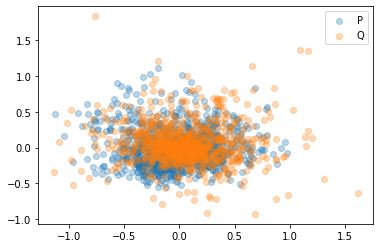

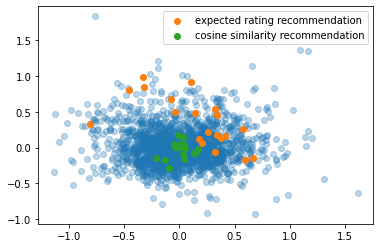

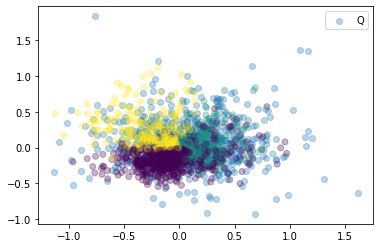

In [ ]:
# Task 5: 차원 축소 및 시각화 (PCA)
# Task 5-1
Z = torch.cat([P,Q], dim=0).detach()

# Task 5-2
pca = PCA(n_components = 2) # sklearn 라이브러리 이용
pca.fit(Z)
Zp = pca.transform(Z)

# Task 5-3-1
plt.scatter(Zp[:len(P),0], Zp[:len(P),1], label='P', alpha=0.3) # P
plt.scatter(Zp[len(P):,0], Zp[len(P):,1], label='Q', alpha=0.3) # Q
plt.legend()
plt.show()

# Task 5-3-2
ur1 = [u13_ratings1[i][0] for i in range(20)] 
ur2 = [u13_ratings2[i][0] for i in range(20)]

plt.scatter(Zp[:,0], Zp[:,1], alpha=0.3)
plt.scatter(Zp[ur1,0], Zp[ur1,1], label="expected rating recommendation")
plt.scatter(Zp[ur2,0], Zp[ur2,1], label="cosine similarity recommendation")
plt.legend()
plt.show()

# Task 5-3-3
assignments, centroids, cost = kmeans(4, movie_points) # cluster 4개(centroid 4개)로 설정

plt.scatter(Zp[len(P):,0], Zp[len(P):,1], alpha=0.3, label = 'Q')
plt.scatter(Zp[:len(P),0], Zp[:len(P),1], c = [assignments[i] for i in assignments], alpha=0.3)
plt.legend()
plt.show()